In [1]:
import os
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
from qqdm.notebook import qqdm
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1, 4"

In [2]:
# You may replace the workspace directory if you want.
workspace_dir = '.'
dataset_dir = '/data/dlcv/hw2/hw2_data'
os.makedirs(workspace_dir, exist_ok=True)

# Training progress bar
# !pip install -q qqdm

In [3]:
import random

import numpy as np

def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# same_seeds(42)

## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [4]:
class DCGANDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.12, contrast=0.12),
        # transforms.RandomRotation(degrees=5),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = DCGANDataset(fnames, transform)
    return dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


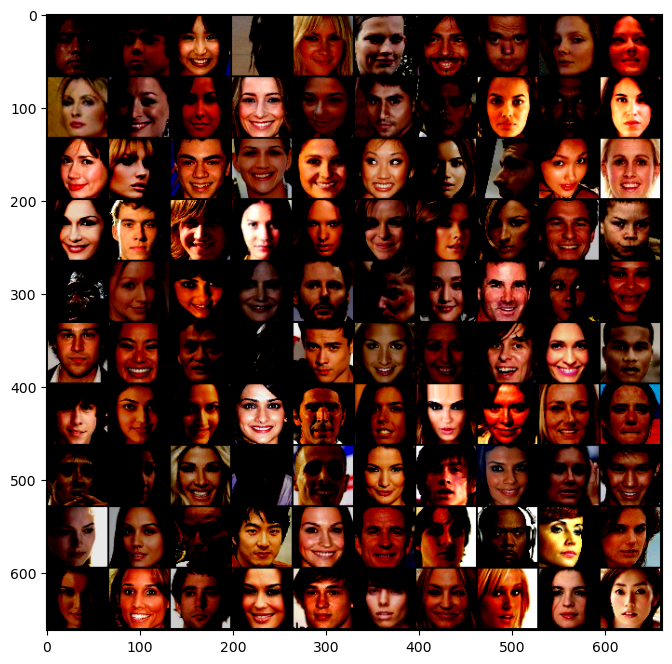

In [5]:
dataset = get_dataset(os.path.join(dataset_dir, 'face/train'))

images = [dataset[i] for i in range(100)]
grid_img = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

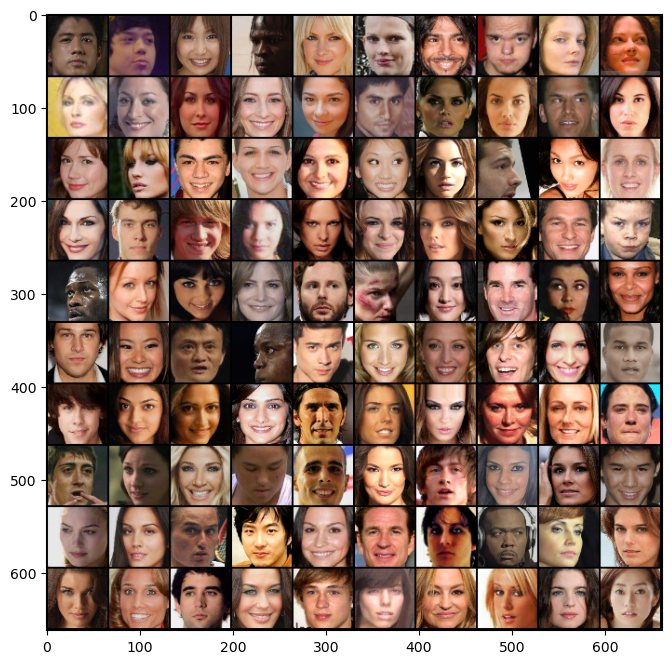

In [6]:
images = [(dataset[i]+1)/2 for i in range(100)]
grid_img = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Model
Here, we use DCGAN as the model structure. Feel free to modify your own model structure.

Note that the `N` of the input/output shape stands for the batch size.

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    """
    Input shape: (N, in_dim)
    Output shape: (N, 3, 64, 64)
    """
    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                                   padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU()
            )
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU()
        )
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4),
            dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh()
        )
        self.apply(weights_init)

    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y

class Discriminator(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()

        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2),
            )
            
        """ Medium: Remove the last sigmoid layer for WGAN. """
        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2), 
            nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4),
            nn.Sigmoid(), 
        )
        self.apply(weights_init)
        
    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

## Training

### Initialization
- hyperparameters
- model
- optimizer
- dataloader

In [8]:
# Training hyperparameters
from random import seed

batch_size = 64
z_dim = 100
z_sample = Variable(torch.randn(100, z_dim)).cuda()
lr = 1e-4

""" Medium: WGAN, 50 epoch, n_critic=5, clip_value=0.01 """
n_epoch = 1000 # 50
n_critic = 1 # 5
# clip_value = 0.01

log_dir = os.path.join(workspace_dir, 'logs')
ckpt_dir = os.path.join(workspace_dir, 'checkpoints')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

tb_dir = os.path.join(workspace_dir, 'tb')
os.makedirs(tb_dir, exist_ok=True)

# Model
G = Generator(in_dim=z_dim).cuda()
D = Discriminator(3).cuda()
print(G)
print(D)
G.train()
D.train()

# Loss
criterion = nn.BCELoss()

""" Medium: Use RMSprop for WGAN. """
# Optimizer
# opt_D = torch.optim.SGD(D.parameters(), lr=lr)
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
# opt_D = torch.optim.RMSprop(D.parameters(), lr=lr)
# opt_G = torch.optim.RMSprop(G.parameters(), lr=lr)

# Scheduler
sch_D = optim.lr_scheduler.ExponentialLR(opt_D, 0.99)
sch_G = optim.lr_scheduler.ExponentialLR(opt_G, 0.99)

# DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# same_seeds(30)

# TensorBoard
writer = SummaryWriter(tb_dir)


Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=False)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l2_5): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()


### Training loop
We store some pictures regularly to monitor the current performance of the Generator, and regularly record checkpoints.

In [149]:
steps = 0
for e, epoch in enumerate(range(n_epoch)):
    # progress_bar = qqdm(dataloader)
    GerLoss = 0
    DisLoss = 0
    for i, data in enumerate(dataloader):
        
        imgs = data
        imgs = imgs.cuda()

        bs = imgs.size(0)

        # ============================================
        #  Train D
        # ============================================
        z = Variable(torch.randn(bs, z_dim)).cuda()
        r_imgs = Variable(imgs).cuda()
        f_imgs = G(z)

        # Label
        r_label = torch.ones((bs)).cuda()
        f_label = torch.zeros((bs)).cuda()

        # Model forwarding
        r_logit = D(r_imgs.detach())
        f_logit = D(f_imgs.detach())
        
        # Compute the loss for the discriminator.
        r_loss = criterion(r_logit, r_label)
        f_loss = criterion(f_logit, f_label)
        loss_D = (r_loss + f_loss) / 2
        DisLoss += loss_D.item()

        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()

        # ============================================
        #  Train G
        # ============================================
        if steps % n_critic == 0:
            # Generate some fake images.
            z = Variable(torch.randn(bs, z_dim)).cuda()
            f_imgs = G(z)

            # Model forwarding
            f_logit = D(f_imgs)
            
            # Compute the loss for the generator.
            loss_G = criterion(f_logit, r_label)
            GerLoss += loss_G.item()

            # Model backwarding
            G.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()
        
        # sch_D.step()    
        # sch_G.step()
        writer.add_scalar('Gan', loss_G.item(), steps)
        writer.add_scalar('Dis', loss_D.item(), steps)
        steps += 1
        
        # Set the info of the progress bar
        #   Note that the value of the GAN loss is not directly related to
        #   the quality of the generated images.
        # progress_bar.set_infos({
        #     'Loss_D': round(loss_D.item(), 4),
        #     'Loss_G': round(loss_G.item(), 4),
        #     'Epoch': e+1, 'lr': lr,
        #     'Step': steps,
        # })
    print("epoch: {}; Loss_D: {} Total_Loss_D: {}; Loss_G: {}; Total_Loss_G: {}".format(e+1, loss_D.item(), DisLoss, loss_G.item(), GerLoss))
    
    writer.add_scalar('Overall G Loss', GerLoss, e+1)
    writer.add_scalar('Overall D Loss', DisLoss, e+1)
    
    
    G.eval()
    if (e+1) % 5 == 0 and (e+1) >= 800: 
        f_imgs_sample = (G(z_sample).data + 1) / 2.0
        filename = os.path.join(log_dir, f'Epoch_{epoch+1:03d}.jpg')
        torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
        print(f' | Save some samples to {filename}.')

    G.train()

    if (e+1)>=800 and (e+1) % 5 == 0:
        # Save the checkpoints.
        torch.save(G.state_dict(), os.path.join(ckpt_dir, f'G_Epoch{epoch+1:03d}.pth'))
        torch.save(D.state_dict(), os.path.join(ckpt_dir, f'D_Epoch{epoch+1:03d}.pth'))



epoch: 1; Loss_D: 0.15580560266971588 Total_Loss_D: 104.82029058218359; Loss_G: 6.009547233581543; Total_Loss_G: 4785.908424317837
epoch: 2; Loss_D: 0.2102818489074707 Total_Loss_D: 151.65928683057427; Loss_G: 3.202814817428589; Total_Loss_G: 2820.347384572029
epoch: 3; Loss_D: 0.26169005036354065 Total_Loss_D: 153.2032373175025; Loss_G: 2.196749687194824; Total_Loss_G: 2481.8474205732346
epoch: 4; Loss_D: 0.2812269330024719 Total_Loss_D: 160.8493648469448; Loss_G: 3.4953842163085938; Total_Loss_G: 2199.1392905712128
epoch: 5; Loss_D: 0.11701658368110657 Total_Loss_D: 146.31779042631388; Loss_G: 2.2745862007141113; Total_Loss_G: 2067.078725323081
 | Save some samples to ./logs/Epoch_005.jpg.
epoch: 6; Loss_D: 0.139656662940979 Total_Loss_D: 132.98112468793988; Loss_G: 3.661275863647461; Total_Loss_G: 2049.8806410729885
epoch: 7; Loss_D: 0.18113026022911072 Total_Loss_D: 150.5175675675273; Loss_G: 2.9869747161865234; Total_Loss_G: 2021.1888920366764
epoch: 8; Loss_D: 0.16910696029663086

### Load model 

### Generate and show some images.


cuda:0


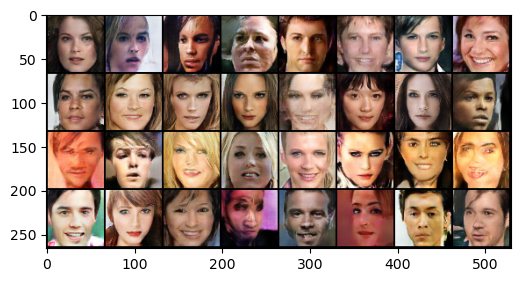

./output


In [11]:
import torch

G = Generator(z_dim)
G.load_state_dict(torch.load(os.path.join(ckpt_dir, 'G_7777_29_91.pth')))
G.eval()
G.cuda()

# Generate 1000 images and make a grid to save them.
same_seeds(30)
n_output = 1000
z_sample = Variable(torch.randn(n_output, z_dim)).cuda()
imgs_sample = (G(z_sample).data + 1) / 2.0
log_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(log_dir, 'result.png')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)

# Show 32 of the images.
grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow=8)
torchvision.utils.save_image(grid_img, 'report_dcgan.png')
plt.figure(figsize=(6,6))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

# Save the generated images.
outputPath = os.path.join(workspace_dir, 'output')
print(outputPath)
os.makedirs(outputPath, exist_ok=True)

# for i in range(1000):
#     torchvision.utils.save_image(imgs_sample[i], f'output/{i+1}.png')


In [13]:
!python -m pytorch_fid --device cuda:0 '/data/dlcv/hw2/hw2_data/face/val' './output'
!python3 face_recog.py --image_dir './output/'

/home/jhccc/anaconda3/envs/dlcv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/jhccc/anaconda3/envs/dlcv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/jhccc/anaconda3/envs/dlcv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  7.86it/s]
FID:  26.985340500420023
Start face recognition...
100%|██████████████████████████████████████| 1000/1000 [00: